In [1]:
from scipy.io import loadmat
from scipy.special import softmax

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F

import time
import os
import copy


import cv2
from PIL import Image
import albumentations 
from albumentations import pytorch as AT
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
 
import warnings
warnings.filterwarnings('once')


plt.ion()   # interactive mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

cuda:0
Tesla P100-PCIE-16GB


In [2]:
pip install --upgrade ipykernel

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     |████████████████████████████████| 120 kB 2.9 MB/s eta 0:00:01
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.1.1
    Uninstalling ipykernel-5.1.1:
      Successfully uninstalled ipykernel-5.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-git 0.11.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 2.1.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


# Working with data

Firstly, I'm loading all the data necessary for training form [here](https://ai.stanford.edu/~jkrause/cars/car_dataset.html)
Here's 2 sets: trainig and testing and the labels along with bounding boxes providet in .mat format. I'm using while training set for training a model and whole test set (with labels) as validation set


In [3]:
#Reading all the .mat files
train_annos = loadmat('../input/cars-devkit/cars_train_annos.mat')
test_annos = loadmat('../input/cars-devkit/cars_test_annos.mat')
labels = loadmat('../input/cars-devkit/cars_meta.mat')
test_annos_with_labels = loadmat('../input/cars-devkit/cars_test_annos_withlabels.mat')

#Write all the labels as Cars models in separate list
labels = labels['class_names'][0]

In [4]:
df = pd.DataFrame(labels)
df[0] = df[0].apply(lambda x: x[0])
df.columns = ['Cars Model']

In [5]:
#Data cleaning
data_train = [[row.flat[0] for row in line] for line in train_annos["annotations"][0]]
columns_train = ["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2", "class", "fname"]
df_train = pd.DataFrame(data_train, columns=columns_train)
df_train['class'] = df_train['class']-1 #we need to make all the lables starting with 0, as putorch requires so.

data_test = [[row.flat[0] for row in line] for line in test_annos_with_labels["annotations"][0]]
columns_test = ["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2","class","fname"]
df_test = pd.DataFrame(data_test, columns=columns_test)
df_test['class'] = df_test['class']-1

Next, I create my own class to load images and labels directly to PyTorch Dataloader without separating all the images by class folders

In [7]:
class CarsDataset(Dataset):
    def __init__(self, datafolder, df=None, transform = transforms.Compose([transforms.ToTensor()])):
        
        self.datafolder = datafolder
        self.labels = df['class'].values
        self.image_fname = df['fname'].values
        self.bboxes = df[["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2"]].values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def crop_bbox(self,bbox,img_fname):
        """ Method cropps image by provided in .mat file bounding boxes
        """
        image = cv2.imread(img_fname)
        l1, l0,_ = image.shape
        
        b0 = bbox[2] - bbox[0]
        b1 = bbox[3] - bbox[1]
        x0n,x1n = max(int(bbox[0] - b0*0.05),0), min(int(bbox[2] + b0*0.05),l0-1)
        y0n,y1n = max(int(bbox[1] - b1*0.05),0), min(int(bbox[3] + b1*0.05),l1-1)
        
        image = image[y0n:y1n,x0n:x1n]
        return  image
    
    def __getitem__(self, idx):
        
        img_name = os.path.join(self.datafolder, self.image_fname[idx])
        label = self.labels[idx]
        image = self.crop_bbox(self.bboxes[idx], img_name)
        
        
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        #Uncomment next 5 rows for training and comment last 3 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image) 
            image = augmented['image']

            return image, label
#        image = Image. fromarray(image).convert('RGB')
 #       image = self.transform(image)
  #      return image, label

Next part is image transformations and loading them to Dataloader. For image transformation I'm using 'albumentations' library. The library performs a diverse set of augmentations for the classification, detection, and segmentation tasks. Some unsual transforms:


*   ShiftScaleRotate - Randomly apply affine transforms: translate, scale and rotate the input
*   JpegCompression -  Decrease Jpeg compression of an image
*   HueSaturationValue - Randomly change hue, saturation and value of the input image





In [8]:
#Set transforms for train and val sets
data_transforms = albumentations.Compose([
    albumentations.Resize(400, 400),
    albumentations.HorizontalFlip(),
    albumentations.RandomBrightnessContrast(),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    albumentations.ImageCompression(80),
    albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    AT.ToTensorV2()
    ])
data_transforms_test = albumentations.Compose([
    albumentations.Resize(400, 400),
    albumentations.Normalize(),
    AT.ToTensorV2()
    ])

#Create Datsets using previously created class
train_set = CarsDataset(datafolder='../input/stanford-cars-dataset/cars_train/cars_train', df=df_train, transform=data_transforms)
test_set = CarsDataset(datafolder='../input/stanford-cars-dataset/cars_test/cars_test',df=df_test, transform=data_transforms_test)

train_sampler = torch.utils.data.SubsetRandomSampler(list(range(len(os.listdir('../input/stanford-cars-dataset/cars_train/cars_train')))))

#Using small batch size due to big images size, as I'm training on free GPU with Google Colab
batch_size = 16
num_workers = 4

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)

dataset_sizes = {'train': len(train_set), 'val':len(test_set)}

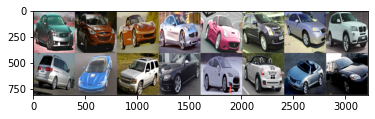

In [9]:
def imshow(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

# Training and validation

In [10]:
def train_model(model, criterion, optimizer, scheduler, model_fname, num_epochs=25):
    time_start = time.time()

    best_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_acc = 0.0

    loss_list_val = []
    loss_list_train = []
    acc_list_val = []
    acc_list_train = []

    for epoch in range(num_epochs):

        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('_' * 85)

        for phase in ['train', 'val']:

            if phase == 'train':
                scheduler.step(epoch_acc)
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = test_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over the dataloader

            for inputs, classes in loader:
                inputs = inputs.to(device)
                classes = classes.to(device)

                optimizer.zero_grad()

                # forward propagation
                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, classes)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Calculate statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == classes.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'val':
                loss_list_val.append(epoch_loss)
                acc_list_val.append(epoch_acc)
            else:
                loss_list_train.append(epoch_loss)
                acc_list_train.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            print('{} Loss: {:.4f} Accuracy: {:.4f}'
                  .format(phase, epoch_loss, epoch_acc))

        print()

    time_elapsed = time.time() - time_start

    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    path = F"{model_fname}"
    torch.save(model.state_dict(), path)

    return loss_list_train, loss_list_val, acc_list_train, acc_list_val

I decided to use Transfer Learning for provided dataset e.x I worked with different variantions of different models(resnet, densenet, vgg, inception), but the best result was with resnextt101, here I'm also using ReduceLROnPlateau, SGD optimizer and CrossEntripy loss as loss function. This combination allowed me to reach 94.7% accuracy on the training set.

In [11]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')

model_ft = models.resnext101_32x8d(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 196)
# model_ft.aux_logits = False

# model_ft = models.densenet121(pretrained=True)
# model.classifier = nn.Sequential(nn.Linear(1024,NUM_CLASSES),
#                                  nn.Sigmoid())  
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='max', patience=2, threshold = 0.9)



Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


  0%|          | 0.00/340M [00:00<?, ?B/s]

In [12]:
loss_list_train, loss_list_val, acc_list_train, acc_list_val = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,'resnext101_32x8d.pth', num_epochs=20)

Epoch 0/19
_____________________________________________________________________________________
train Loss: 4.7268 Accuracy: 0.0648
val Loss: 3.6676 Accuracy: 0.1821

Epoch 1/19
_____________________________________________________________________________________
train Loss: 3.1218 Accuracy: 0.3348
val Loss: 2.0537 Accuracy: 0.5768

Epoch 2/19
_____________________________________________________________________________________
train Loss: 1.8814 Accuracy: 0.6419
val Loss: 1.1039 Accuracy: 0.7929

Epoch 3/19
_____________________________________________________________________________________
train Loss: 1.0649 Accuracy: 0.8253
val Loss: 0.6776 Accuracy: 0.8581

Epoch 4/19
_____________________________________________________________________________________
train Loss: 0.6374 Accuracy: 0.9031
val Loss: 0.4449 Accuracy: 0.9042

Epoch 5/19
_____________________________________________________________________________________
train Loss: 0.4053 Accuracy: 0.9506
val Loss: 0.3713 Accuracy: 

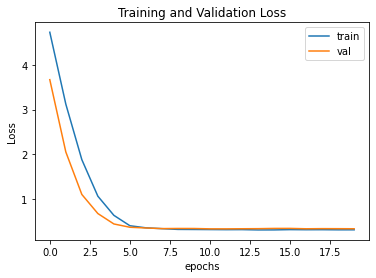

In [13]:
plt.plot(loss_list_train, label='train')
plt.plot(loss_list_val, label='val')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

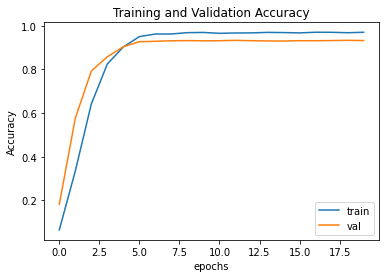

In [14]:
plt.plot(acc_list_train, label='train')
plt.plot(acc_list_val, label='val')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()